In [1]:
import gurobipy as grb
import numpy as np
import itertools

# Optimization of Eurobot robot strategy
Evgenii Safronov

Mikhail Kurenkov

# Eurobot 2018 description

In [1]:
import IPython.display 

### Project motivation
This year Eurobot challenge has 2 main tasks for 2 robots to be done by team:
    1. Collect balls of two colors and deposite them separately by color into two places on the field
    2. Collect cubes of different colors, build vertical towers from them and deposit them at certain place.
Second task is more complicated, because big amount of bonus points is given, if deposited tower of our cubes contains plan - 3 cubes in row of specified color. Plan is not known until start of each match, so robots need to adapt for it and strategies are hardly hardcoded. Number of possible plans are $N = \frac{5 \cdot 4 \cdot 3}{2} = 30$ (divided by two because it can be flipped). 

Also, some heaps of cubes might be blocked by opponent team and we might need to re-optimize our strategy. 

On the map below
1. Bonus plan is circled in red
2. Heaps of cubes are circled in orange
3. Towers deposits is circled in blue

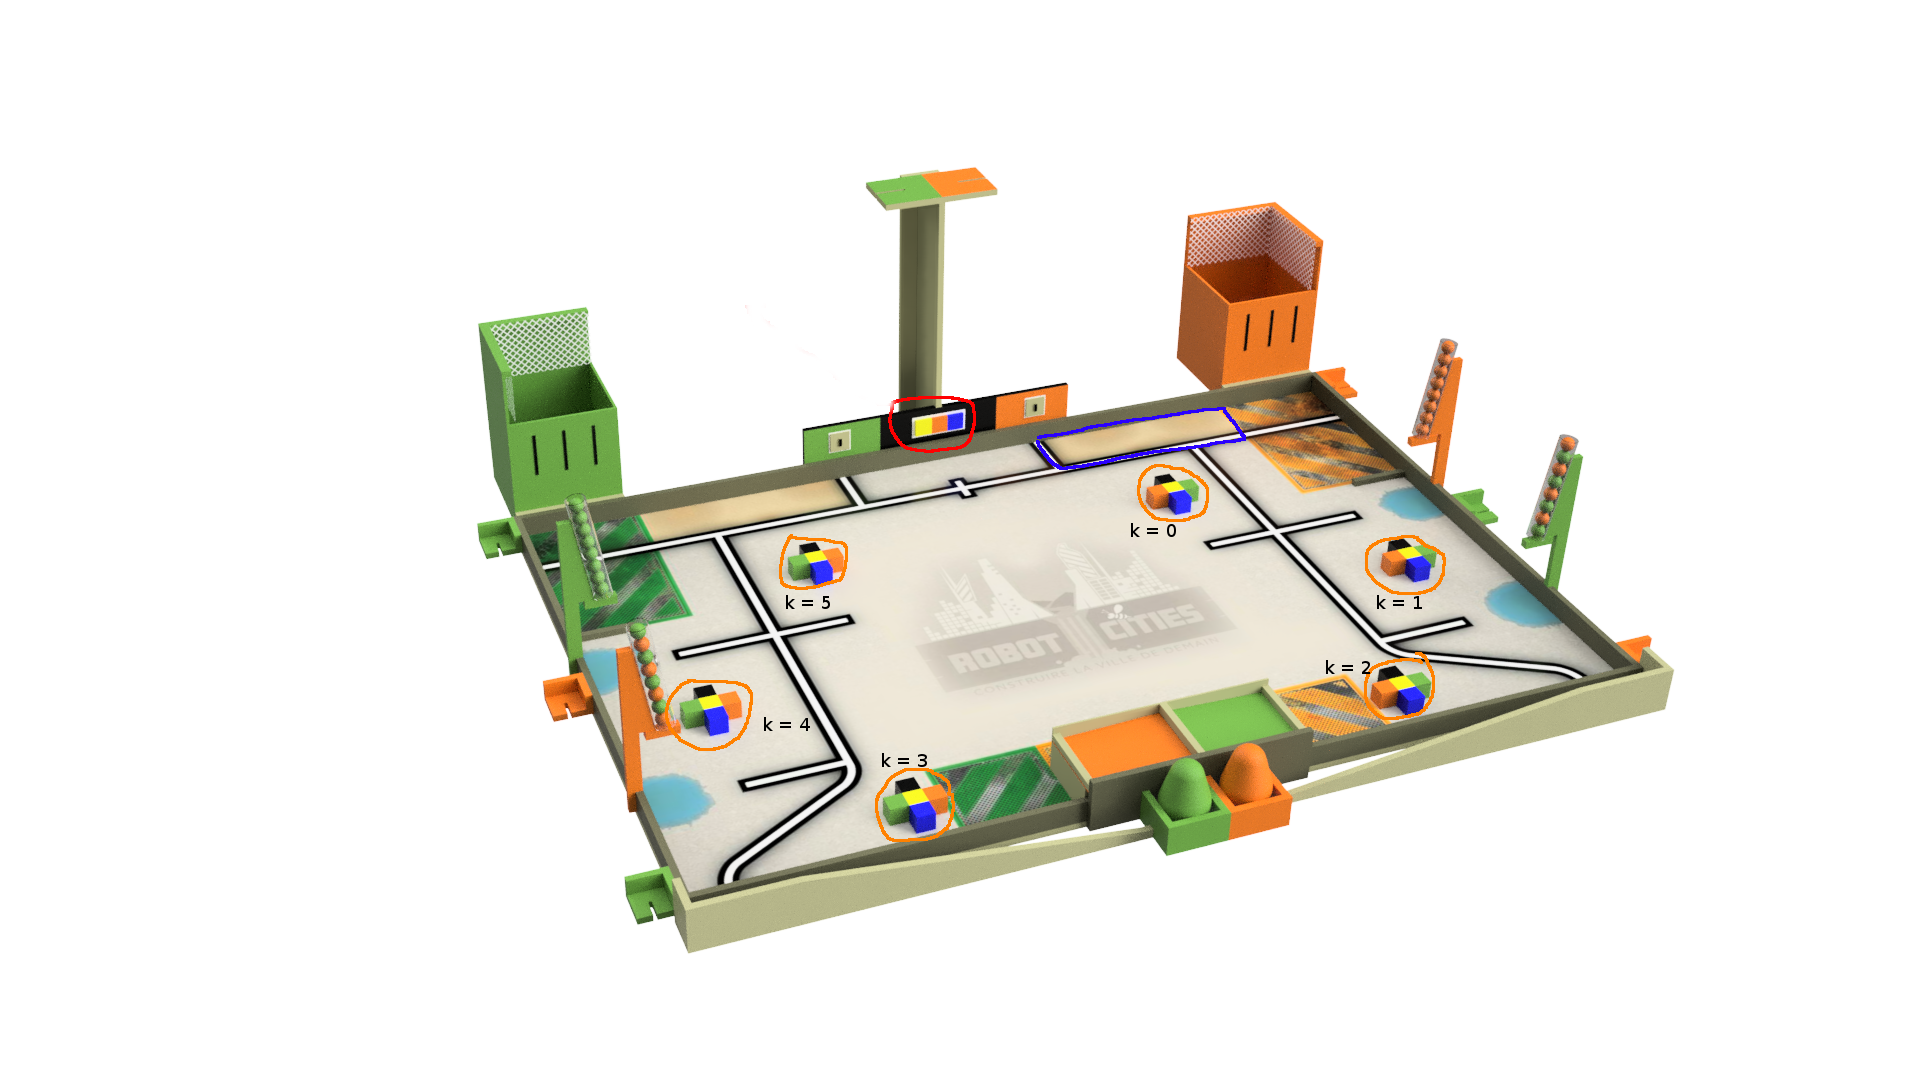

In [5]:
IPython.display.Image(filename='opt_map2.png')

Below are possible towers constructed and deposited until the end of match.

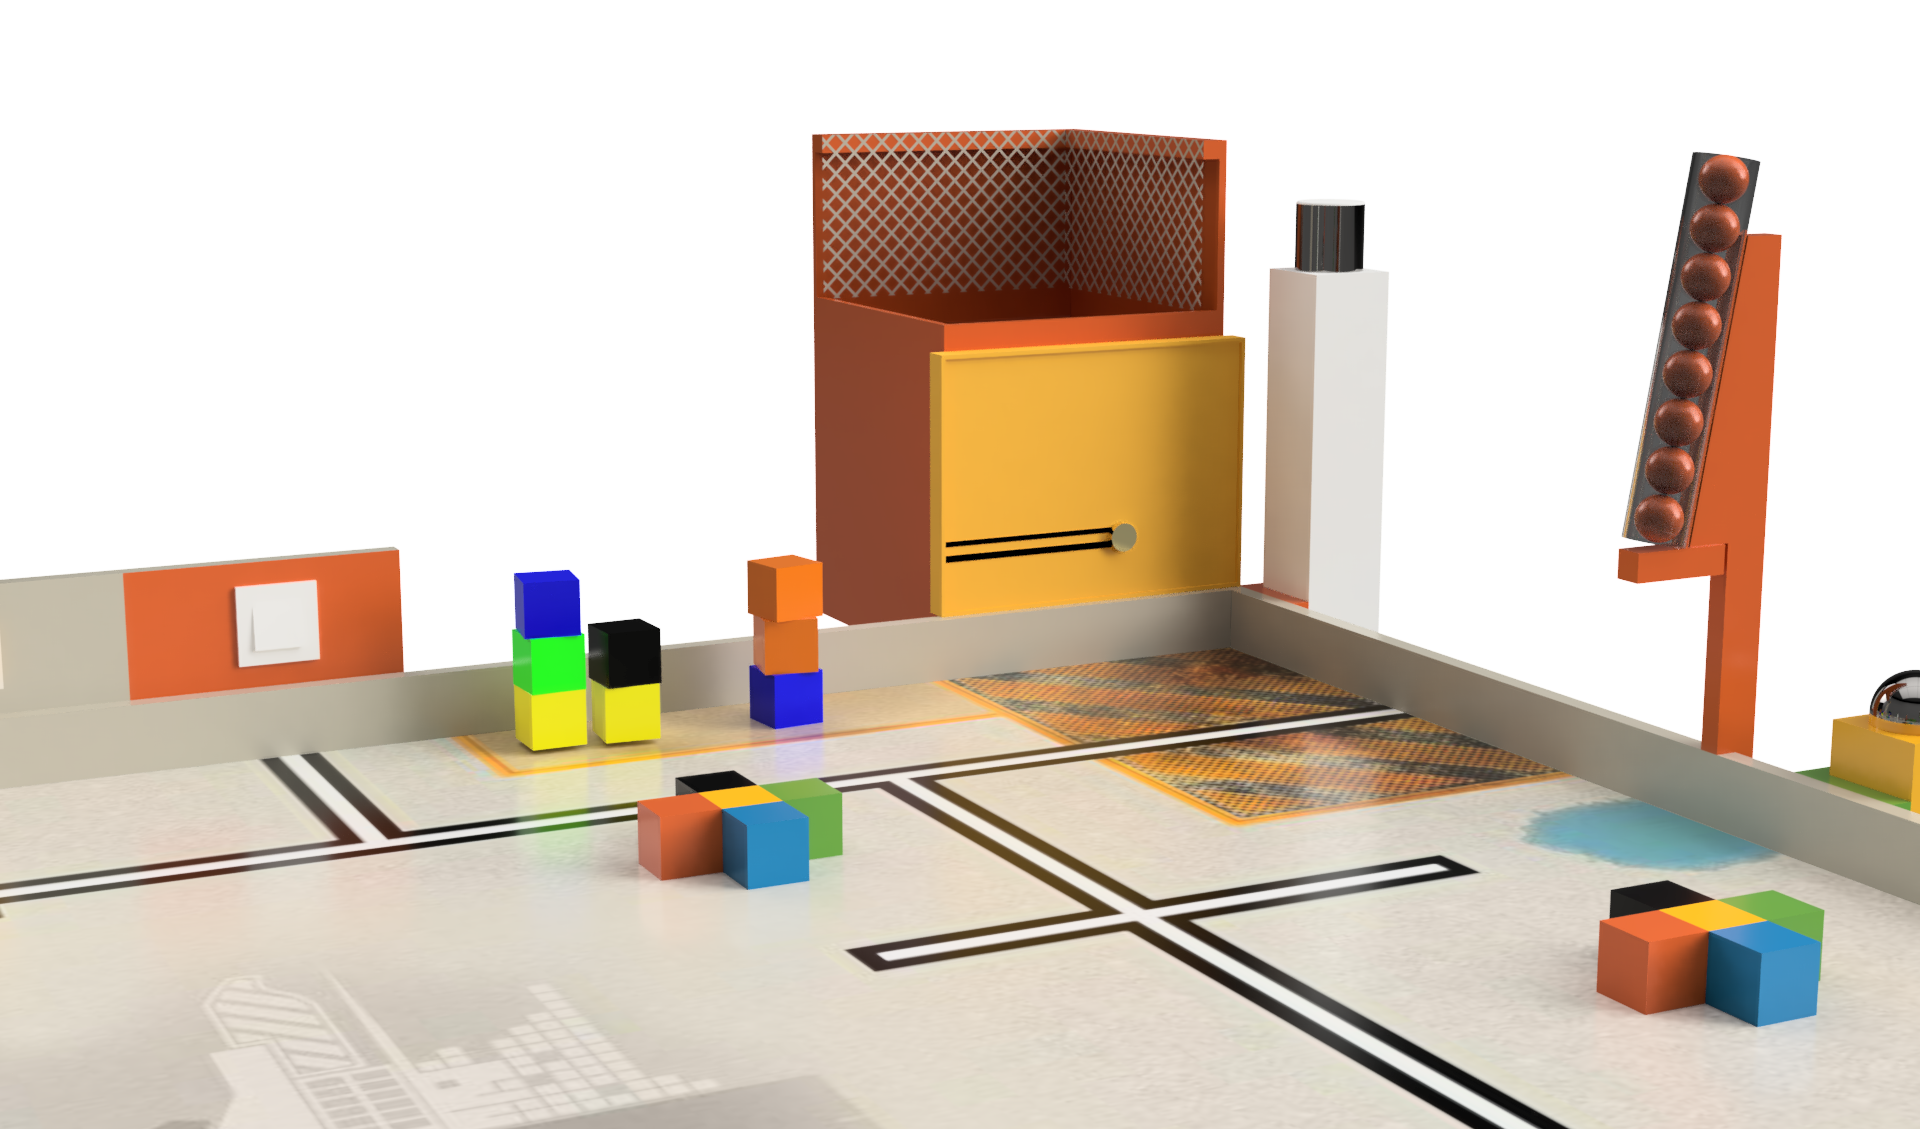

In [6]:
IPython.display.Image(filename='opt_towers.png')

We see on the picture 3 towers of height 3, 2 and 3. None of them contains bonus plan of __yellow, orange, blue__ cubes. So, no bonus points will be accounted (if bonus plan like on map above). 

# Dynamic programming

To solve Eurobot problem the first approach is dynamic programming. To simplify initial task we assume that we pick all cubes from one heap and only then we move to another heap. After picking from a heap we have some sequence of cubes that our manipulators hold. And idea of dynamic approach is that we can calculate minimal time to pick certain towers of cubes by Belman equation: 

# Integer quadratic programming

Here we formulate our problem in following way:

We want to choose some robot actions from the whole set of possible actions on the field. All of them require some time to execute and also some time between each other for robot to move on the table. Some actions can be done in parallel (e.g. picking 2 cubes by 2 manipulators of robot at the same time). 

So, we want first to find some robot strategy (action subset) that gives maximum points for the match for the limited time of match. Then, if there are many possible solutions, minimize the time for this amount of points.

There are also some actions except cubes picking, but they are most interesting and their order changes for different plans. That's why we decided to start from only cubes picking actions. Let's describe their definition:
$$ X_{s,i,j,k,l,m} \in \{0,1\}$$

$s \in \left[0,14\right]$ index state for the order of action,

$i \in \left[0,2\right]$ number of manipulator, which picks some cube,

$j \in \left[0,4\right]$ means cube color and also uniquely gives position in the heap,

$k \in \left[0,5\right]$ enumerates heaps of cubes,

$l \in \left[0,4\right]$ for order inside $i$-th manipulator,

$m \in \left[0,3\right]$ means from which side (of 4 cube sides) we pick it.

$i,j,k,m$ affects position of robot for picking actions - affects time between two actions. $s$ - order, to provide constraint of unique actions each step and also some other constraints below. $l$ is needed for bonus plan constraint.


In [289]:
S, I, J, K, L, M = 15, 3, 5, 6, 5, 4
plan = [2, 4, 3]
def iterer(*args):
    return itertools.product(*[range(x_) for x_ in args])

In [3]:
model = grb.Model("eurobot")

In [4]:
x = model.addVars(range(S), range(I), range(J), range(K), range(M), name = 'x', vtype=grb.GRB.BINARY)
y = model.addVars(range(S), range(I), range(J), range(L), name = 'y', vtype=grb.GRB.BINARY)

In [308]:
model.remove(model.getConstrs())

## Unique action per step

In [309]:
model.addConstrs((x.sum(s, '*', '*', '*', '*') == 1 for s in iterer(S)));
model.addConstrs((y.sum(s, i, j, '*') == x.sum(s, i, j, '*', '*') for s, i, j in iterer(S, I, J)));

## Unique cubes and places constraints

In [310]:
model.addConstrs((y.sum('*', i, '*', l) == 1 for i, l in iterer(I, L)));
model.addConstrs((x.sum('*', '*',j, k, '*') <= 1 for j, k in iterer(J, K)));

## Tower height

In [311]:
model.addConstrs((y.sum('*', i, '*', '*') == 5 for i in iterer(I)));

## Bonus plan requirements

In [312]:
pi = model.addVars(range(I), range(6), name = 'pi', vtype=grb.GRB.BINARY)

plan_locations = [[0, 1, 2], [1, 2, 3], [2, 3, 4], [4, 3, 2], [3, 2, 1], [2, 1, 0]]
for i, t in iterer(I, 6):
    for j in range(3):
        model.addConstr(pi[i, t] <= y.sum('*', i, plan[j],  plan_locations[t][j]))

xi = model.addVars(range(I), name='xi', vtype=grb.GRB.BINARY)
model.addConstrs((xi[i] <= pi.sum(i, '*') for i in range(I)))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>}

## l-Ordering

In [313]:
for s, l1, i in iterer(S,L,I):
    for l2 in range(l1+1,L):
        model.addConstr(grb.quicksum((y.sum(s_,i,'*',l1) for s_ in iterer(s) )) >= y.sum(s,i,'*',l2))

## Ban collisions with other cubes

In [314]:
j_rel = np.zeros((J+1,J+1,2))
j_map = np.array([
                 [-1,-1,-1,-1,-1],
                 [-1,-1, 2,-1,-1],
                 [-1, 3, 4, 1,-1],
                 [-1,-1, 0,-1,-1],
                 [-1,-1,-1,-1,-1]
                 ])

j_on_map = np.zeros((J+1,2))


for i1 in range(j_map.shape[0]):
    for j1 in range(j_map.shape[1]):
        if j_map[i1,j1] >= 0:
            j_on_map[j_map[i1,j1]] = np.array([j1,i1])

for i1 in range(j_map.shape[0]):
    for j1 in range(j_map.shape[1]):
        for i2 in range(j_map.shape[0]):
            for j2 in range(j_map.shape[1]):
                if j_map[i1,j1] >= 0 and j_map[i2,j2] >= 0:
                    if i1 != i2 or j1 != j2:
                        j_rel[j_map[i1,j1],j_map[i2,j2]] = np.array([j2-j1,i2-i1])
                        
# we need just to have free space on 3 'kletka' around the manipulator
def m_manipulator(i,m):
    return (m+i-1)%4

only_non_free_places = [np.array([0,-1]),np.array([-1,0]),np.array([0,1]),np.array([1,0])]

def only_non_free_dif(i,m):
    direction =  m_manipulator(i,m)
    return only_non_free_places[direction]

def our_position(j1):
    return j_on_map[j1]

def list_of_possible_breaks(j1,i,m):
    toreturn = []
    dxy = [np.array([0,1]),np.array([1,0]),np.array([-1,0]),np.array([0,-1])]
    for dd in dxy:
        if (dd != only_non_free_dif(i,m)).any():
            yx = j_on_map[j1] + dd
            if j_map[int(yx[1]),int(yx[0])] >= 0:
                toreturn.append(j_map[int(yx[1]),int(yx[0])])
    return toreturn

list_of_possible_breaks(2, 2, 3)

[4]

In [315]:
def debug_possible_breaks(j1, i, m):
    return [0] if j1 == 4 else []

In [316]:
for s, i, j, k, m in iterer(S, I, J, K, M):
    cubes_to_peak = list_of_possible_breaks(j, i, m)
#     print("%d %d %d"%(i,j,m) + ' ' + str(cubes_to_peak))
#         expr = grb.LinExpr()
#         for s_prev, cube in itertools.product(range(s), cubes_to_peak):
#             expr += x.sum(s_prev, '*', cube, k, '*', '*')
    for cube in cubes_to_peak:
        model.addConstr(grb.quicksum((x.sum(s_prev, '*', cube, k, '*') for s_prev in range(s))) >= x.sum(s, i, j, k, m))

## Time

In [317]:
v = 20
t_p = 2 # time of picking
t_r = 1 # time of rotation on pi / 2
t_m = 2 # time of moving on 6 cm

picking_points = np.zeros((5, 4, 3, 3))
cubes_coords = np.array([[0, -1], [1, 0], [0, 1], [-1, 0], [0, 0]])
l1 = np.array([[[1, 0], [0, 1], [-1, 0]],
               [[0, 1], [-1, 0], [0, -1]],
               [[-1, 0], [0, -1], [1, 0]],
               [[0, -1], [1, 0], [0, 1]]])

picking_points[..., :2] = cubes_coords[:, np.newaxis, np.newaxis, :] + l1[np.newaxis, :, :, :]
picking_points[..., 2] = np.array(range(4))[np.newaxis, :, np.newaxis]

points_2 = np.reshape(picking_points, (60, 3))
small_time_2 = t_m * np.abs(points_2[:, np.newaxis, 0] - points_2[np.newaxis, :, 0]) + \
             t_m * np.abs(points_2[:, np.newaxis, 1] - points_2[np.newaxis, :, 1]) + \
             t_r * ((points_2[:, np.newaxis, 2] - points_2[np.newaxis, :, 1]) % 4)
        
small_time = np.where(small_time_2 == 0, 0, small_time_2 + t_p)
heap_points = np.array([[54, 85, 0], [119, 30, 0], [150, 110, 0], [150, 190, 0], [119, 270, 0], [54, 215, 0]])
all_picking_points = np.reshape(points_2[np.newaxis, :, :2] * 6 + heap_points[:, np.newaxis, :2], (360, 2))
big_time = np.sum((heap_points[:, np.newaxis] - heap_points[np.newaxis, :]) ** 2, axis=2) ** 0.5 / v 
times = np.sum((all_picking_points[:, np.newaxis] - all_picking_points[np.newaxis, :]) ** 2, axis=2) ** 0.5 / v + t_p
for i in range(6):
    times[i * 60: (i + 1) * 60, i * 60: (i + 1) * 60] = small_time
small_time = small_time.reshape(5, 4, 3, 5, 4, 3)
times = times.reshape(6, 5, 4, 3, 6, 5, 4, 3)
np.all(times >= 0)

True

In [318]:
%%time
f = model.addVars(range(S), range(I), range(J), range(M), name = 'f', vtype=grb.GRB.BINARY)
model.addConstrs((x.sum(s, i, j, '*', m) == f[s, i, j, m] for s, i, j, m in iterer(S, I, J, M)))
# gen = (f[s, i_1, j_1, m_1] * f[s + 1, i_2, j_2, m_2] * \
#        times[k_1, j_1, m_1, i_1, k_2, j_2, m_2, i_2] for s, i_1, j_1, k_1, m_1, i_2, j_2, k_2, m_2, l_1, l_2 \
#        in iterer(S - 1, I, J, K, M, I, J, K, M, L, L))
gen_1 = (f[s, i_1, j_1, m_1] * f[s + 1, i_2, j_2, m_2] * \
       small_time[j_1, m_1, i_1, j_2, m_2, i_2] for s, i_1, j_1, m_1, i_2, j_2, m_2 \
       in iterer(S - 1, I, J, M, I, J, M))
km = model.addVars(range(S), range(K), name = 'km', vtype=grb.GRB.BINARY)
model.addConstrs((x.sum(s, '*', '*', k , '*') == km[s, k] for s, k in iterer(S, K)))
gen_2 = (km[s, k_1] * km[s+1, k_2] * \
       big_time[k_1, k_2] for s, k_1, k_2 \
       in iterer(S - 1, K, K)) 
# model.addConstr(grb.quicksum(gen) <= T, 'time')
left_part_time_1 = grb.quicksum(gen_1)
left_part_time_2 = grb.quicksum(gen_2)
left_part_time = left_part_time_1 + left_part_time_2

CPU times: user 2.22 s, sys: 4 ms, total: 2.23 s
Wall time: 2.25 s


## Picking from one heap

In [ ]:
for k in range(3):
    for i in range(5):
        for k_other in range(K):
            if k_other != k:
                model.addConstr(x.sum(k*5 + i,'*','*',k_other,'*') == 0)

## Objective (min $t$ task)

In [320]:
model.addConstr(xi.sum('*') == 3)

<gurobi.Constr *Awaiting Model Update*>

In [321]:
model.setObjective(left_part_time, grb.GRB.MINIMIZE)

## Objective (max $\xi$ task)

In [302]:
T = 150
model.addConstr(left_part_time <= T, 'time');

In [303]:
obj = xi.sum('*')
model.setObjective(obj, grb.GRB.MAXIMIZE)

## Optimization 

In [331]:
model.Params.TimeLimit = 300.0
model.update()
model.optimize()

Parameter TimeLimit unchanged
   Value: 300.0  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 8341 rows, 21774 columns and 605553 nonzeros
Model has 49518 quadratic objective terms
Model has 13 quadratic constraints
Variable types: 0 continuous, 21774 integer (21774 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e+00, 3e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
  QRHS range       [2e+02, 2e+02]
Presolved: 1422 rows, 7476 columns, 33372 nonzeros
Presolved model has 27990 quadratic objective terms

Continuing optimization...

 66480 32865   16.04716   47    6   47.54716    8.54716  82.0%  36.6 1211s
 66959 33127 -521.68315   43   18   47.54716    8.54716  82.0%  36.4 1216s
 67333 33296 infeasible   45        47.54716    8.54716  82.0%  36.4 1221s
 67715 33495 infeasible   36        47.54716    8.54716  82.0%  36.4 1228s
 68103 33698 -129

## Optimization result 

In [332]:
model.printAttr('x')


    Variable            x 
-------------------------
x[0,2,1,0,0]            1 
x[1,2,3,0,2]            1 
x[2,1,0,0,0]            1 
x[3,0,2,0,3]            1 
x[4,2,4,0,1]            1 
x[5,1,0,1,0]            1 
x[6,1,3,1,3]            1 
x[7,2,2,1,1]            1 
x[8,0,4,1,0]            1 
x[9,2,1,1,0]            1 
x[10,0,3,2,0]            1 
x[11,0,0,2,1]            1 
x[12,0,1,2,2]            1 
x[13,1,4,2,0]            1 
x[14,1,2,2,2]            1 
  y[0,2,1,0]            1 
  y[1,2,3,1]            1 
  y[2,1,0,0]            1 
  y[3,0,2,0]            1 
  y[4,2,4,2]            1 
  y[5,1,0,1]            1 
  y[6,1,3,2]            1 
  y[7,2,2,3]            1 
  y[8,0,4,1]            1 
  y[9,2,1,4]            1 
 y[10,0,3,2]            1 
 y[11,0,0,3]            1 
 y[12,0,1,4]            1 
 y[13,1,4,3]            1 
 y[14,1,2,4]            1 
     pi[0,0]            1 
     pi[1,3]            1 
     pi[2,4]            1 
       xi[0]            1 
       xi[1]           

In [333]:
left_part_time.getValue()

47.547160107241929

In [334]:
left_part_time_1.getValue()

39.0

In [273]:
left_part_time_2.getValue()

8.5471601072419308

# Conclusion

## Evgenii Safronov
State different constraints and 

## Mikhail Kurenkov
Formulate dynamic programming approach